In [ ]:
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# read male and female comments
male_comment = pd.read_csv('/home/haters/Downloads/Toxicity_Detection/output_perspective/output_score/male_comments_outcome_final.csv')
female_comment = pd.read_csv('/home/haters/Downloads/Toxicity_Detection/output_perspective/output_score/female_comments_outcome_final_24.csv')

In [4]:
# define a function to plot the distribution of scores as percentage histograms
def plot_score_distribution(dataframe, score_columns, bins=20, range=(0, 1), color='b'):
    """
    Plots the distribution of scores as percentage histograms.
    
    Parameters:
        dataframe (pd.DataFrame): The input data frame containing the scores.
        score_columns (list of str): List containing the names of the score columns to plot.
        bins (int): Number of bins for the histogram.
        range (tuple): The range of the histogram bins.
    """
    if len(score_columns) != 2:
        raise ValueError("score_columns list must contain exactly two column names.")

    plt.figure(figsize=(18, 6))

    for i, score_column in enumerate(score_columns, 1):
        plt.subplot(1, 2, i)
        counts, bin_edges, _ = plt.hist(dataframe[score_column], bins=bins, range=range, edgecolor='k', alpha=0.7)
        percentages = counts / len(dataframe[score_column]) * 100
        plt.cla()
        plt.bar(bin_edges[:-1], percentages, width=(bin_edges[1] - bin_edges[0]), edgecolor='k', color = color, alpha=0.7)
        plt.xlabel(f'{score_column.replace("_", " ").title()}', fontsize=14)
        plt.ylabel('Percentage (%)', fontsize=16)
        plt.title(f'Distribution of {score_column.replace("_", " ").title()}', fontsize=14)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

    plt.tight_layout()
    plt.show()

#### Male Comments - Initial Score Distribution

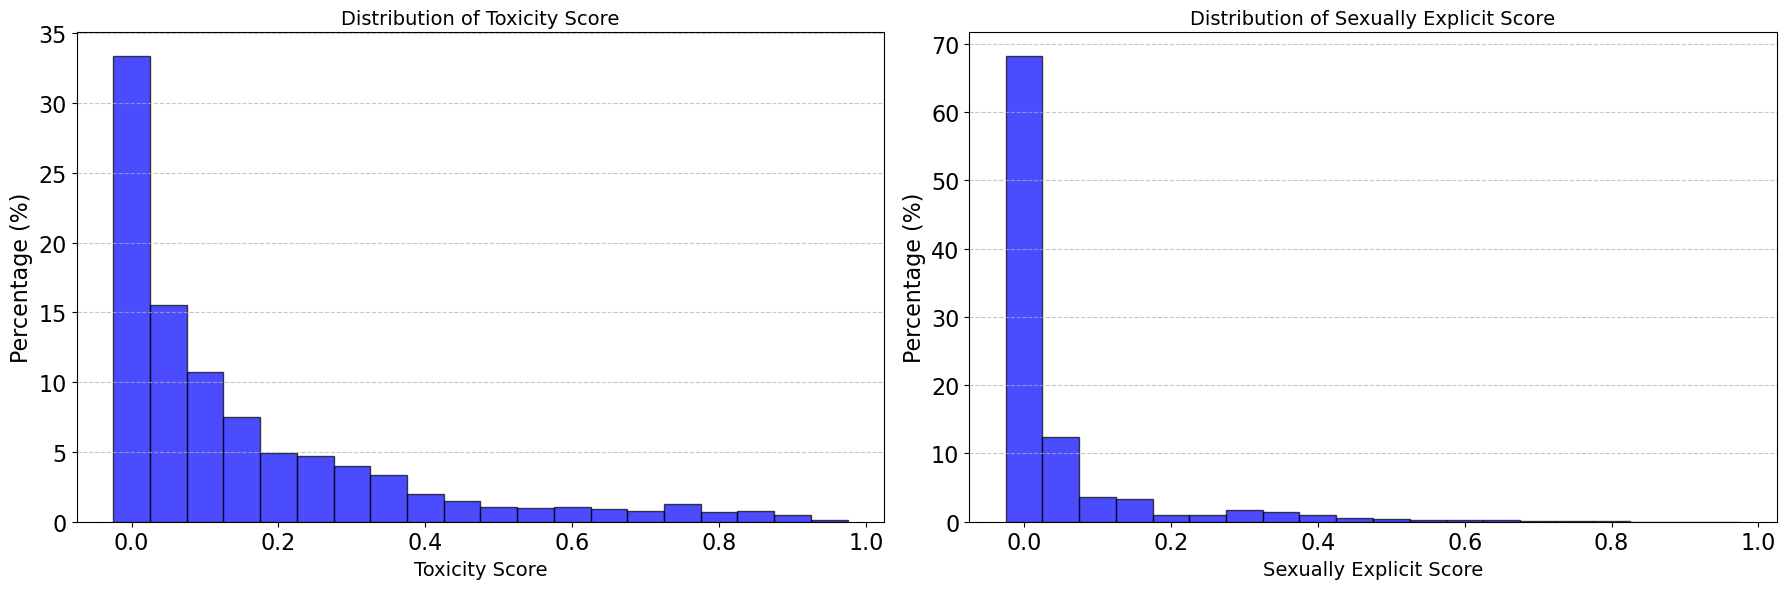

In [5]:
plot_score_distribution(male_comment, ['toxicity_score', 'sexually_explicit_score'])

#### Female Comments - Initial Score Distribution

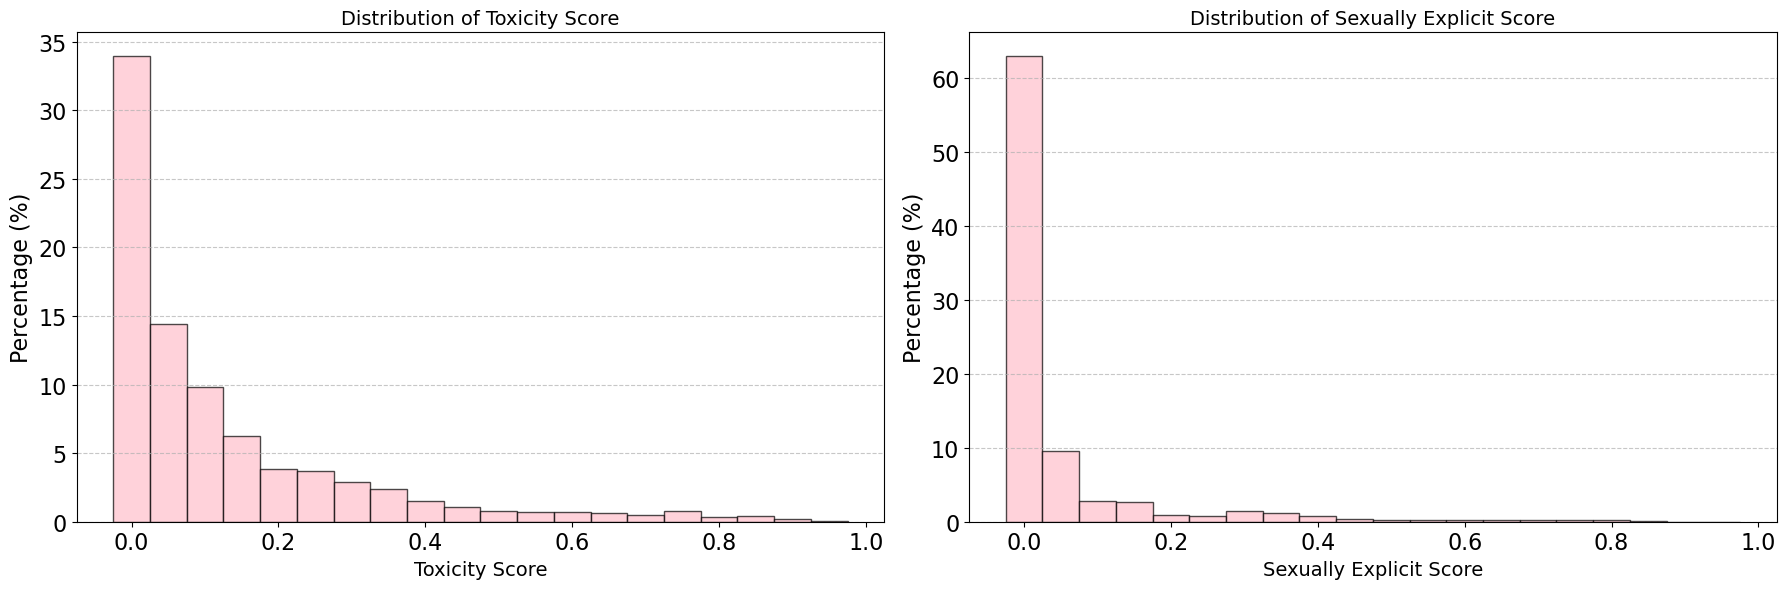

In [6]:
# distribution of scores female comments
plot_score_distribution(female_comment, ['toxicity_score', 'sexually_explicit_score'], color = 'pink')

#### Filter toxicity_score > 0.5  and sexually_explicit_score >0.5
##### this threshold value is just an initial one

In [7]:
# filter toxicity_score > 0.5  and sexually_explicit_score >0.5 this threshold value is just an initial one
male_comment_filtered = male_comment[(male_comment['toxicity_score'] > 0.5) | (male_comment['sexually_explicit_score'] > 0.5)]
female_comment_filtered = female_comment[(female_comment['toxicity_score'] > 0.5) | (female_comment['sexually_explicit_score'] > 0.5)]

In [8]:
print(male_comment_filtered.shape[0])
print (female_comment_filtered.shape[0])

37265
165156


In [9]:
print(male_comment_filtered[male_comment_filtered['toxicity_score'] > 0.5].shape[0])
print(male_comment_filtered[male_comment_filtered['sexually_explicit_score'] > 0.5].shape[0])


36942
7103


In [10]:
print(female_comment_filtered[female_comment_filtered['toxicity_score'] > 0.5].shape[0])
print(female_comment_filtered[female_comment_filtered['sexually_explicit_score'] > 0.5].shape[0])

162338
53155


- For male comments, 37265 (**8.12%**)  rows were selected when use 0.5 as a threshold value for both labels,
- among them, 36942 were toxic (**8.05%**), 7103 were sexually explicit (**1.55%**)
- For female comments, 165156 (**5.18%**) rows were selected when use 0.5 as a threshold value for both labels
- among them, 162338 were toxic (**5.10%**), 53155 were sexually explicit (**1.67%**)


In [11]:
# define a function to plot the distribution of scores as percentage histograms per artist
def plot_artist_score_distribution(male_s_df, male_s_filtered_df, score_columns, threshold=0.5, bins=20, range=(0, 1), colors=['orange', 'red']):
    """
    Plots the distribution of toxicity and sexually explicit scores as percentage histograms per artist.
    
    Parameters:
        male_s_df (pd.DataFrame): The original data frame containing the scores.
        male_s_filtered_df (pd.DataFrame): The filtered data frame containing the scores above certain threshold.
        score_columns (list of str): List containing the names of the score columns to plot.
        threshold (float): The threshold value to filter scores.
        bins (int): Number of bins for the histogram.
        range (tuple): The range of the histogram bins.
        colors (list of str): List of colors for the bars in the histogram.
    """
    if len(score_columns) != 2:
        raise ValueError("score_columns list must contain exactly two column names.")
    
    # get the original total rows of each artist
    com_counts = male_s_df.groupby('artist').size().reset_index(name='com_counts')

    # get the total rows of each artist after filtering
    grouped = male_s_filtered_df.groupby('artist').size().reset_index(name='toxic_and_sexual_counts')
    toxicity_counts = male_s_filtered_df[male_s_filtered_df[score_columns[0]] > threshold].groupby('artist').size().reset_index(name='toxicity_counts')
    sexually_explicit_counts = male_s_filtered_df[male_s_filtered_df[score_columns[1]] > threshold].groupby('artist').size().reset_index(name='sexually_explicit_counts')

    # merge
    merged_counts = pd.merge(grouped, com_counts, on='artist', how='left')
    merged_counts = pd.merge(merged_counts, toxicity_counts, on='artist', how='left')
    merged_counts = pd.merge(merged_counts, sexually_explicit_counts, on='artist', how='left')

    # NaN = 0
    merged_counts.fillna(0, inplace=True)

    # Calculate percentages
    merged_counts['toxicity_percentage'] = (merged_counts['toxicity_counts'] / merged_counts['com_counts']) * 100
    merged_counts['sexually_explicit_percentage'] = (merged_counts['sexually_explicit_counts'] / merged_counts['com_counts']) * 100

    
    plt.figure(figsize=(18, 6))

    # toxicity_score > threshold
    plt.subplot(1, 2, 1)
    plt.bar(merged_counts['artist'], merged_counts['toxicity_percentage'], color=colors[0], alpha=0.7)
    plt.xlabel('Artist', fontsize=16)
    plt.ylabel('Percentage (%)', fontsize=16)
    plt.title(f'{score_columns[0].replace("_", " ").title()} > {threshold} per Artist', fontsize=16)
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)

    # sexually_explicit_score > threshold
    plt.subplot(1, 2, 2)
    plt.bar(merged_counts['artist'], merged_counts['sexually_explicit_percentage'], color=colors[1], alpha=0.7)
    plt.xlabel('Artist', fontsize=16)
    plt.ylabel('Percentage (%)', fontsize=16)
    plt.title(f'{score_columns[1].replace("_", " ").title()} > {threshold} per Artist', fontsize=16)
    plt.xticks(rotation=90, fontsize=16)
    plt.yticks(fontsize=16)

    plt.tight_layout()
    plt.show()
    return merged_counts

#### Male Aritists - Comments

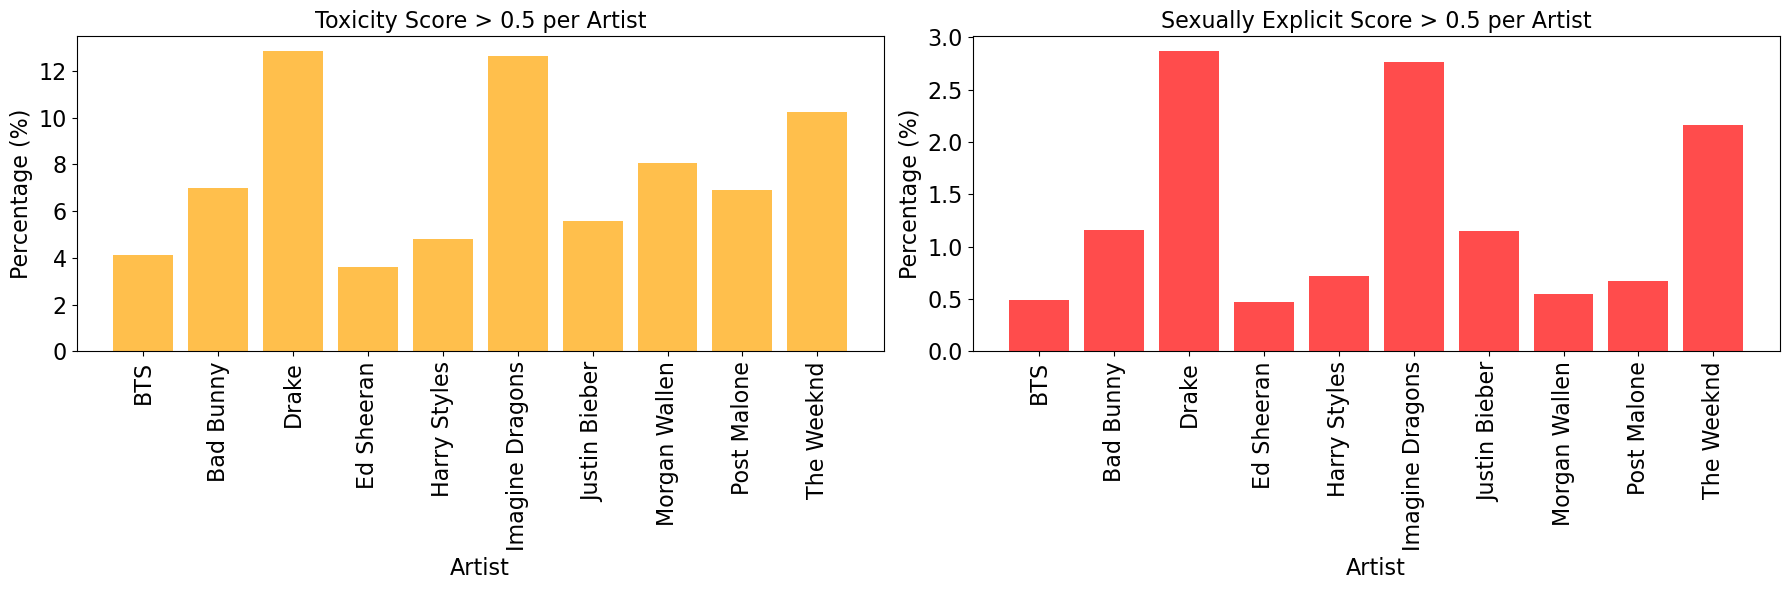

In [12]:
merged_counts_male = plot_artist_score_distribution(male_comment, male_comment_filtered, ['toxicity_score', 'sexually_explicit_score'], threshold=0.5, colors=['orange', 'red'])

In [13]:
# calculate the ratio
merged_counts_male['toxicity_percentage'] = (merged_counts_male['toxicity_counts'] / merged_counts_male['com_counts']) * 100
merged_counts_male['sexually_explicit_percentage'] = (merged_counts_male['sexually_explicit_counts'] / merged_counts_male['com_counts']) * 100

In [14]:
display(merged_counts_male)

,artist,toxic_and_sexual_counts,com_counts,toxicity_counts,sexually_explicit_counts,toxicity_percentage,sexually_explicit_percentage
0,BTS,6375,152714,6325,750,4.141729,0.491114
1,Bad Bunny,1852,26363,1839,305,6.975686,1.156924
2,Drake,24445,188732,24221,5411,12.833542,2.867028
3,Ed Sheeran,1794,49438,1787,232,3.614628,0.469275
4,Harry Styles,1018,20925,1005,150,4.802867,0.716846
5,Imagine Dragons,137,1084,137,30,12.638376,2.767528
6,Justin Bieber,151,2689,150,31,5.578282,1.152845
7,Morgan Wallen,716,8872,716,49,8.070334,0.552299
8,Post Malone,145,2083,144,14,6.913106,0.672108
9,The Weeknd,632,6042,618,131,10.228401,2.168156


Drake, Imagine Dragons and The Weeknd have received the most **toxic** comments and the most **sexually explicit** submission

#### Female Aritists - Comments

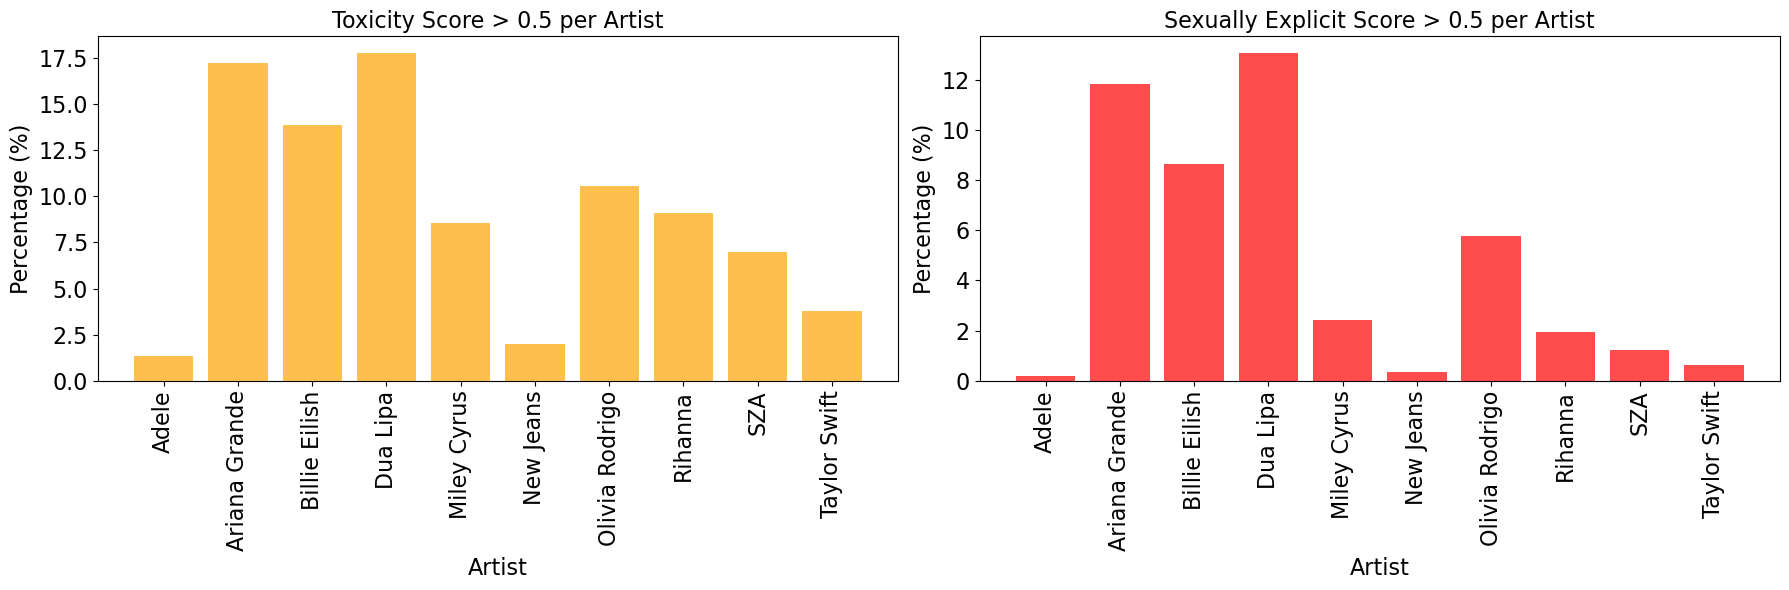

In [15]:
merged_counts_female = plot_artist_score_distribution(female_comment, female_comment_filtered, ['toxicity_score', 'sexually_explicit_score'], threshold=0.5, colors=['orange', 'red'])

In [16]:
merged_counts_female

,artist,toxic_and_sexual_counts,com_counts,toxicity_counts,sexually_explicit_counts,toxicity_percentage,sexually_explicit_percentage
0,Adele,328,24038,320,48,1.331226,0.199684
1,Ariana Grande,17214,97788,16840,11563,17.220927,11.824559
2,Billie Eilish,13228,93126,12919,8042,13.872603,8.635612
3,Dua Lipa,11516,63232,11247,8263,17.786880,13.067751
4,Miley Cyrus,2888,33024,2833,797,8.578609,2.413396
5,New Jeans,1099,55199,1095,182,1.983732,0.329716
6,Olivia Rodrigo,12730,117565,12434,6761,10.576277,5.750861
7,Rihanna,2057,22186,2020,435,9.104841,1.960696
8,SZA,1363,19338,1354,237,7.001758,1.225566
9,Taylor Swift,102733,2663730,101276,16827,3.802037,0.631708


TS has received the most **toxic** and **sexually explicit** comments by count, but Ariana Grande, Dua Lipa and Billie Eilish have received most **toxic** and **sexually explicit** comments by ratio


#### Significance Testing
##### Toxicity

In [3]:
# add a new column to indicate whether the comment is toxic or not based on the toxicity_score threshold
male_comment['is_toxic'] = male_comment['toxicity_score'] > 0.5
female_comment['is_toxic'] = female_comment['toxicity_score'] > 0.5

In [4]:
# get the summary of toxic and non-toxic comments for each
male_com_summary = male_comment['is_toxic'].value_counts()
female_com_summary = female_comment['is_toxic'].value_counts()
print("Male Comment Summary:\n", male_com_summary)
print("Female Comment Summary:\n", female_com_summary)

Male Comment Summary:
 is_toxic
False    422004
True      36942
Name: count, dtype: int64
Female Comment Summary:
 is_toxic
False    3026888
True      162338
Name: count, dtype: int64


In [5]:
# calculate the ratio of toxic comments 
male_toxic_ratio = male_com_summary.get(True, 0) / male_com_summary.sum()
female_toxic_ratio = female_com_summary.get(True, 0) / female_com_summary.sum()
print(f"Male Toxic Comment Ratio: {male_toxic_ratio}")
print(f"Female Toxic Comment Ratio: {female_toxic_ratio}")

Male Toxic Comment Ratio: 0.08049312991070845
Female Toxic Comment Ratio: 0.0509020056904089


In [10]:
# construct the contingency table for Chi-square test
contingency_table = pd.DataFrame({
    'Male': [male_com_summary.get(True, 0), male_com_summary.sum() - male_com_summary.get(True, 0)],
    'Female': [female_com_summary.get(True, 0), female_com_summary.sum() - female_com_summary.get(True, 0)]
}, index=['Toxic', 'Non-toxic'])

# Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-square value: {chi2}')
print(f'Chi-square test p-value: {p}')

# z-test
count = [male_com_summary.get(True, 0), female_com_summary.get(True, 0)]
nobs = [male_com_summary.sum(), female_com_summary.sum()]
stat, p_val = proportions_ztest(count, nobs)
print(f'z value: {stat}')
print(f'z-test p-value: {p_val}')

# Fisher's Exact test
contingency_matrix = contingency_table.values
odds_ratio, p_value = fisher_exact(contingency_matrix, alternative='two-sided')


print("Fisher's Exact Test:")
print(f"Odds Ratio: {odds_ratio}")
print(f"P-value: {p_value}")

Chi-square value: 6802.447994130467
Chi-square test p-value: 0.0
z value: 82.48042798584045
z-test p-value: 0.0
Fisher's Exact Test:
Odds Ratio: 1.6322248928921477
P-value: 0.0


- Therefore, the chi-square test shows that a significant relation exists between the gender and the toxic comment
- further, the z-test shows that the ratios of toxic comment between two gender groups are significantly different. To be specific, male singers received higher ratio of toxic comment than female singers

#### Sexually Explicit

In [11]:
male_comment['is_sexually_explicit'] = male_comment['sexually_explicit_score'] > 0.5
female_comment['is_sexually_explicit'] = female_comment['sexually_explicit_score'] > 0.5
male_com_summary_se = male_comment['is_sexually_explicit'].value_counts()
female_com_summary_se = female_comment['is_sexually_explicit'].value_counts()
print("Male Comment Summary:\n", male_com_summary_se)
print("Female Comment Summary:\n", female_com_summary_se)

Male Comment Summary:
 is_sexually_explicit
False    451843
True       7103
Name: count, dtype: int64
Female Comment Summary:
 is_sexually_explicit
False    3136071
True       53155
Name: count, dtype: int64


In [12]:
male_se_ratio = male_com_summary_se.get(True, 0) / male_com_summary_se.sum()
female_se_ratio = female_com_summary_se.get(True, 0) / female_com_summary_se.sum()
print(f"Male Sexually Explicit Comment Ratio: {male_se_ratio}")
print(f"Female Sexually Explicit Comment Ratio: {female_se_ratio}")

Male Sexually Explicit Comment Ratio: 0.015476766329807864
Female Sexually Explicit Comment Ratio: 0.016667053385366858


In [14]:
# construct the contingency table for Chi-square test
contingency_table = pd.DataFrame({
    'Male': [male_com_summary_se.get(True, 0), male_com_summary_se.sum() - male_com_summary_se.get(True, 0)],
    'Female': [female_com_summary_se.get(True, 0), female_com_summary_se.sum() - female_com_summary_se.get(True, 0)]
}, index=['Sexually_expliciy', 'Non_sexually_explicit'])

# Chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f'Chi-square value: {chi2}')
print(f'Chi-square test p-value: {p}')

# z-test
count = [male_com_summary_se.get(True, 0), female_com_summary_se.get(True, 0)]
nobs = [male_com_summary_se.sum(), female_com_summary_se.sum()]
stat, p_val = proportions_ztest(count, nobs)
print(f'z value: {stat}')
print(f'z-test p-value: {p_val}')

# Fisher's Exact test
contingency_matrix = contingency_table.values
odds_ratio, p_value = fisher_exact(contingency_matrix, alternative='two-sided')


print("Fisher's Exact Test:")
print(f"Odds Ratio: {odds_ratio}")
print(f"P-value: {p_value}")

Chi-square value: 34.91877383887754
Chi-square test p-value: 3.437503126496419e-09
z value: -5.91540436083329
z-test p-value: 3.31061234034551e-09
Fisher's Exact Test:
Odds Ratio: 0.92746177659697
P-value: 2.5432479379518154e-09


- chi-square test shows that a significant relation exists between the gender and sexually explicit comment.
- further, z-test shows that the ratios of sexually explicit comment between two gender groups are significantly different. Specifically, female singers received a higher ratio of sexually explicit comment than male singers